In [2]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [19]:
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: mps


In [20]:
mnist_train = dsets.FashionMNIST(root='F_MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.FashionMNIST(root='F_MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

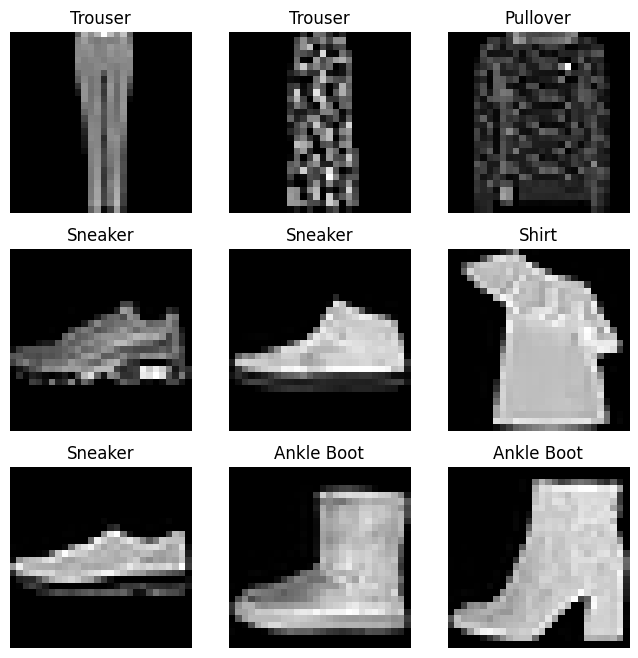

In [53]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
batch_size = 32
training_epochs = 20
data_loader = DataLoader(dataset=mnist_train,
                        batch_size=batch_size, # 배치 크기는 100
                        shuffle=True,
                        drop_last=True)

In [5]:
torch.manual_seed(777)

In [26]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64,10)
        self.dropout = nn.Dropout(0.5)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight.data)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        return x
        
model = MLP()
model.to(device)

criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)
        prediction = model(X)
        optimizer.zero_grad()
        cost = criterion(prediction, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))


print('Learning finished')

Accuracy: 0.09489999711513519
Label:  Dress
Prediction:  T-Shirt


/opt/homebrew/lib/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/homebrew/lib/python3.10/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


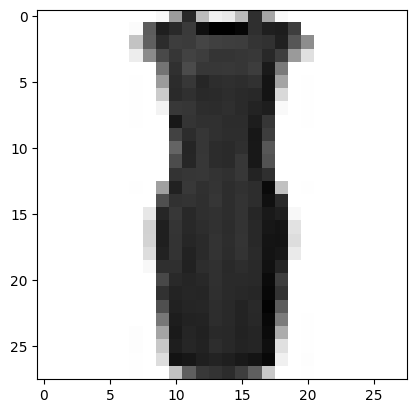

In [31]:
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test) # trained model
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', labels_map[Y_single_data.item()])
    single_prediction = model(X_single_data)
    print('Prediction: ', labels_map[torch.argmax(single_prediction, 1).item()])

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()

In [83]:
torch.manual_seed(777)

In [84]:
batch_size = 64
training_epochs = 20
train_loader = DataLoader(dataset=mnist_train,
                        batch_size=batch_size,
                        shuffle=True,
                        drop_last=True)

test_loader = DataLoader(dataset=mnist_test,
                        batch_size=batch_size, 
                        shuffle=True)

In [85]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64,10)
        self.dropout = nn.Dropout(0.5)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight.data)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        return x
        
model = MLP().to(device)
criterion = nn.CrossEntropyLoss() # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [88]:
cost_dict = {'train':[], 'test':[]}
test_acc_arr = []

def train(model, data_loader, optimizer):
    model.train()  # 신경망을 학습 모드로 전환
    train_cost = 0
    total_batch = len(data_loader)

    for i, (X, Y) in enumerate(data_loader):
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)
        optimizer.zero_grad()
        prediction = model(X)
        cost = criterion(prediction, Y)
        cost.backward()
        optimizer.step()

        train_cost += cost / total_batch
    cost_dict['train'].append(train_cost)
    print('Epoch:', '{}'.format(i + 1), 'cost =', '{:.9f}'.format(train_cost))

def validation(test_loader, model):
    model.eval()
    test_cost = 0
    correct = 0
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_pred = model(X_test)
            test_cost += F.cross_entropy(y_pred, y_test, reduction='sum').item()
            _, predicted = torch.max(y_pred.data, 1)
            correct += predicted.eq(y_test.data.view_as(predicted)).sum()
    
    test_cost /= len(test_loader.dataset)
    cost_dict['test'].append(test_cost)

    test_acc = correct / len(test_loader.dataset)
    test_acc_arr.append(test_acc)
    print('test acc ::: ', test_acc , ' test loss :::', test_cost)
    

In [89]:
for epoch in range(1, training_epochs+1):
    train(model, train_loader, optimizer)
    validation(test_loader, model)

Epoch: 937 cost = 0.380178094
test acc :::  tensor(0.8570, device='mps:0')  test loss ::: 0.391090604364872
Epoch: 937 cost = 0.356677592
test acc :::  tensor(0.8696, device='mps:0')  test loss ::: 0.3647321024894714
Epoch: 937 cost = 0.345733613
test acc :::  tensor(0.8724, device='mps:0')  test loss ::: 0.3672386265039444
Epoch: 937 cost = 0.331157655
test acc :::  tensor(0.8786, device='mps:0')  test loss ::: 0.3522733371257782
Epoch: 937 cost = 0.317484081
test acc :::  tensor(0.8729, device='mps:0')  test loss ::: 0.35681665058135986
Epoch: 937 cost = 0.310540855
test acc :::  tensor(0.8639, device='mps:0')  test loss ::: 0.37053097739219665
Epoch: 937 cost = 0.301201224
test acc :::  tensor(0.8785, device='mps:0')  test loss ::: 0.3448276225566864
Epoch: 937 cost = 0.293819696
test acc :::  tensor(0.8782, device='mps:0')  test loss ::: 0.3483364345550537
Epoch: 937 cost = 0.284207612
test acc :::  tensor(0.8793, device='mps:0')  test loss ::: 0.3421774806022644
Epoch: 937 cost = 

Accuracy: 0.8743000030517578
Label:  Ankle Boot
Prediction:  Ankle Boot


/opt/homebrew/lib/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/homebrew/lib/python3.10/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


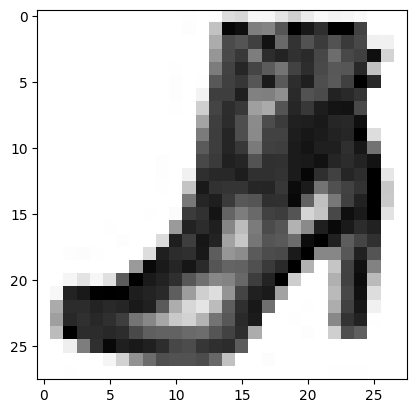

In [90]:
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test) # trained model
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', labels_map[Y_single_data.item()])
    single_prediction = model(X_single_data)
    print('Prediction: ', labels_map[torch.argmax(single_prediction, 1).item()])

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()

In [91]:
cost_dict['train'][0].item()

0.3801780939102173

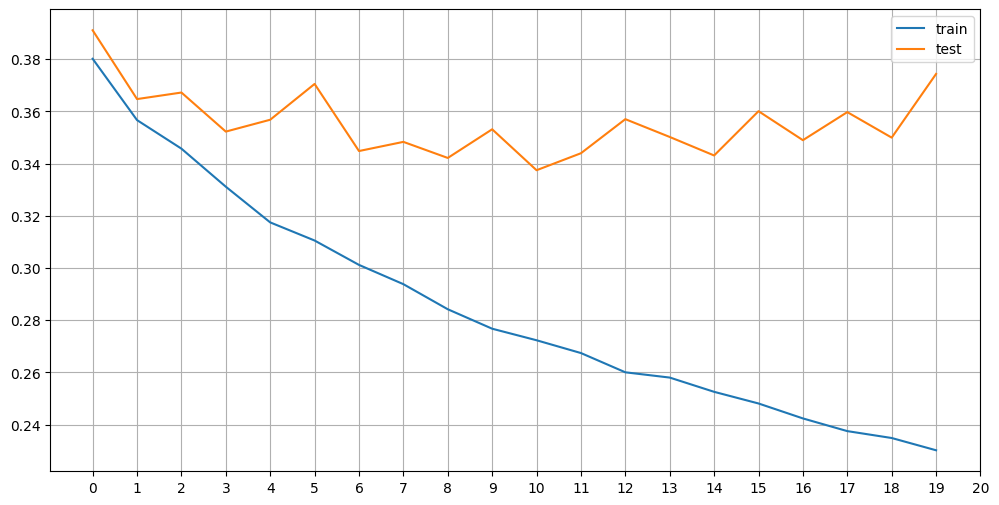

In [92]:
plt.figure(figsize=(12,6))
plt.plot([t.item() for t in cost_dict['train']], label='train')
plt.plot(cost_dict['test'], label='test')
plt.grid()
plt.xticks(range(training_epochs+1))
plt.legend()
plt.show()

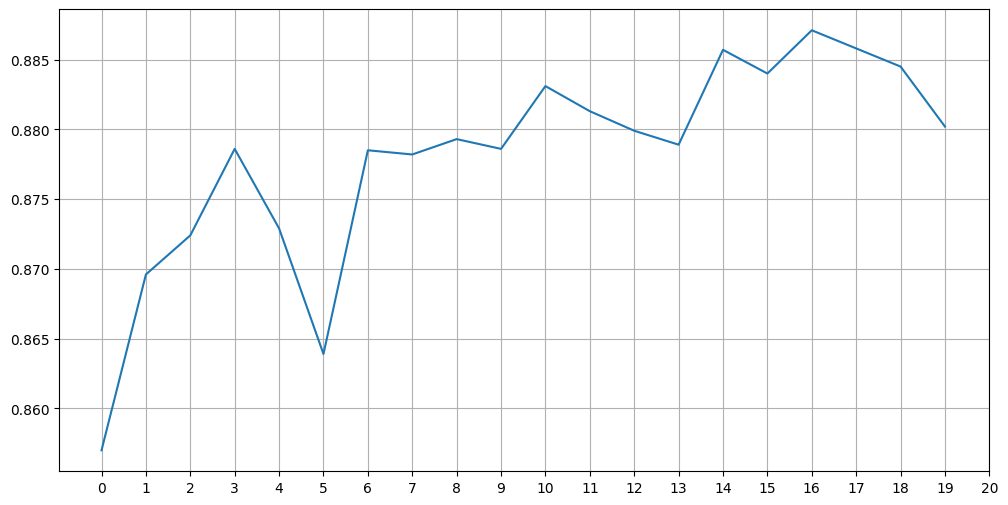

In [93]:
plt.figure(figsize=(12,6))
plt.plot([t.item() for t in test_acc_arr])
plt.xticks(range(training_epochs+1))
plt.grid()
plt.show()